In [1]:
%matplotlib notebook

In [2]:
from sys import path
import splipy as sp
from splipy import curve_factory
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Car turning

We model a tiny roadpiece consisting of a straight line going from (1,-1) to (1,0) followed by a circular turn. We can create this curve using the following code

<IPython.core.display.Javascript object>


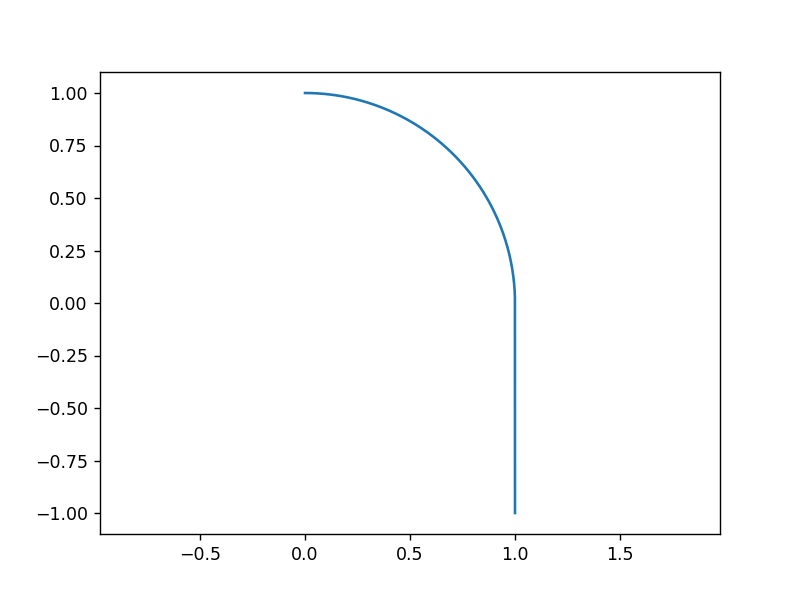

(-0.04999999999999993, 1.05, -1.1, 1.1)

In [3]:
straight_piece = curve_factory.line([1,-1], [1,0])
curve_piece = curve_factory.circle_segment(r=1, theta=np.pi/2)
road = straight_piece.append(curve_piece)

t = np.linspace(road.start(0), road.end(0), 360)
x = road(t)
plt.figure()
plt.plot(x[:,0], x[:,1])
plt.axis('equal')

However this is terrible road design since it will create awfull driving conditions. The best way to see this is by looking at the acceleration vector. We can plot both the velocity and the acceleration by a call to  `.derivative()` with respectively 1st and 2nd order derivative. This is shown in the code below along with a simple animation of this.

<IPython.core.display.Javascript object>


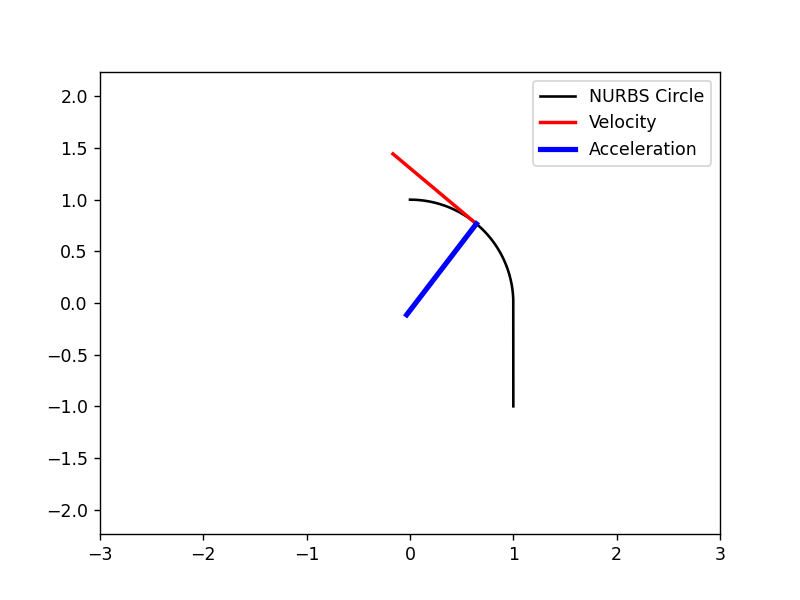

In [4]:
n = 250
t = np.linspace(road.start(0), road.end(0), n)  # parametric evaluation points
x = road(t)                                     # physical (x,y)-coordinates, size (n,2)
v = road.derivative(t, 1)                       # velocity at all points
a = road.derivative(t, 2)                       # acceleration at all points

# plot the circle and get reference to the acceleration/velocity lines which we
# will update during animation
fig = plt.figure()
plt.plot(x[:,0], x[:,1], 'k-')
velocity,     = plt.plot([x[0,0], x[0,0]+v[0,0]], [x[0,1], x[0,1]+v[0,1]], 'r-', linewidth=2)
acceleration, = plt.plot([x[0,0], x[0,0]+a[0,0]], [x[0,1], x[0,1]+a[0,1]], 'b-', linewidth=3)
plt.axis('equal')
plt.legend(('NURBS Circle', 'Velocity', 'Acceleration'))

# update the velocity/acceleration lines for frame *i* in the animation
def animate(i):
    velocity.set_data(    [x[i,0], x[i,0]+v[i,0]], [x[i,1], x[i,1]+v[i,1]])
    acceleration.set_data([x[i,0], x[i,0]+a[i,0]], [x[i,1], x[i,1]+a[i,1]])
    plt.axis([-3, 3, -3, 3])
    
# create and show the animation
ani = animation.FuncAnimation(fig, animate, np.arange(1,n), interval=24)
plt.show()

### Problem 1
The acceleration vector really isn't the right thing to plot here. What we look at is the steering whell of the car which for straight section is fixed in place straight ahead and for the curved section is fixed in place for a turn. The change between these two states have zero measure. While the second derivative (acceleration) is related to the steering whell, it is not really equal. See if you can find another measure of turning wheel from the [curve API](https://sintef.github.io/Splipy/basic_classes.html#splipy.Curve) and plot this as a function of time.

### Problem 2
Can you create a smoother turn by doing a spline curve fit of sufficient smoothness? From question 1 we've already established that we are looking for a $C^2$ curve approximation. Do an alternative curve approximation

# Motion capture lab

The following raw data was captured from the High Precision Position (HIPPO) lab in Trondheim.

In [5]:
f = open('gait_test_kort.tsv', 'r')
for i  in range(13): print(f.readline(), end='')
f.close()

NO_OF_FRAMES	7225
NO_OF_CAMERAS	6
NO_OF_MARKERS	39
FREQUENCY	200
NO_OF_ANALOG	0
ANALOG_FREQUENCY	0
DESCRIPTION	--
TIME_STAMP	2021-11-02, 11:13:14.780	500719.00747640
DATA_INCLUDED	3D
MARKER_NAMES	LFHD	RFHD	RBHD	LBHD	C7	RBAK	T10	LPSI	RPSI	LASI	RASI	CLAV	STRN	RTHI	LTHI	RKNE	LKNE	RTIB	LTIB	RANK	LANK	RHEE	LHEE	RTOE	LTOE	RSHO	RUPA	RELB	RFRM	RWRA	RWRB	RFIN	LSHO	LUPA	LELB	LFRM	LWRA	LWRB	LFIN
TRAJECTORY_TYPES	Measured	Measured	Mixed	Measured	Mixed	Measured	Measured	Mixed	Measured	Mixed	Mixed	Measured	Mixed	Mixed	Mixed	Measured	Mixed	Mixed	Mixed	Mixed	Mixed	Mixed	Mixed	Mixed	Mixed	Measured	Mixed	Mixed	Mixed	Mixed	Mixed	Mixed	Measured	Mixed	Mixed	Mixed	Mixed	Mixed	Measured
LFHD X	LFHD Y	LFHD Z	RFHD X	RFHD Y	RFHD Z	RBHD X	RBHD Y	RBHD Z	LBHD X	LBHD Y	LBHD Z	C7 X	C7 Y	C7 Z	RBAK X	RBAK Y	RBAK Z	T10 X	T10 Y	T10 Z	LPSI X	LPSI Y	LPSI Z	RPSI X	RPSI Y	RPSI Z	LASI X	LASI Y	LASI Z	RASI X	RASI Y	RASI Z	CLAV X	CLAV Y	CLAV Z	STRN X	STRN Y	STRN Z	RTHI X	RTHI Y	RTHI Z	LTHI X	LTHI Y	LTHI Z	RKNE X	RKNE Y	RKNE Z	L

Following the header there is a 7225 rows of data (39 markers times (x,y,z)-coordinate) for a grand total of 7225x117 sized matrix.

In [6]:
x = np.loadtxt('motion_capture.data')
print(x.shape)

(7225, 117)


The tags are defined as indicated by this image <img src='MARKERSET.jpg'>

And a video of the capture can be seen at https://youtu.be/IPvXXYAlnas

In [7]:
lfin = x[:,-3:]

We first create a suitable approximation space. For now we use 4th order splines, using a knot vector of size 50.

In [8]:
knots = [0,0,0] + list(np.linspace(0,1,150)) + [1,1,1]
b = sp.BSplineBasis(order=4, knots=knots)

The data is captured uniformely so the time stamps between values are uniformely spaced

In [9]:
t = np.linspace(0,1,lfin.shape[0])

We then do a least square fit of the data and plot this

In [10]:
# same plotting calls as in the notebook 03 - factory methods
def plot_3D_curve(curve):
    t = np.linspace(curve.start(0), curve.end(0), 350)
    x = curve(t)
    fig = plt.gcf()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(x[:,0], x[:,1], x[:,2])
    plt.show()

<IPython.core.display.Javascript object>


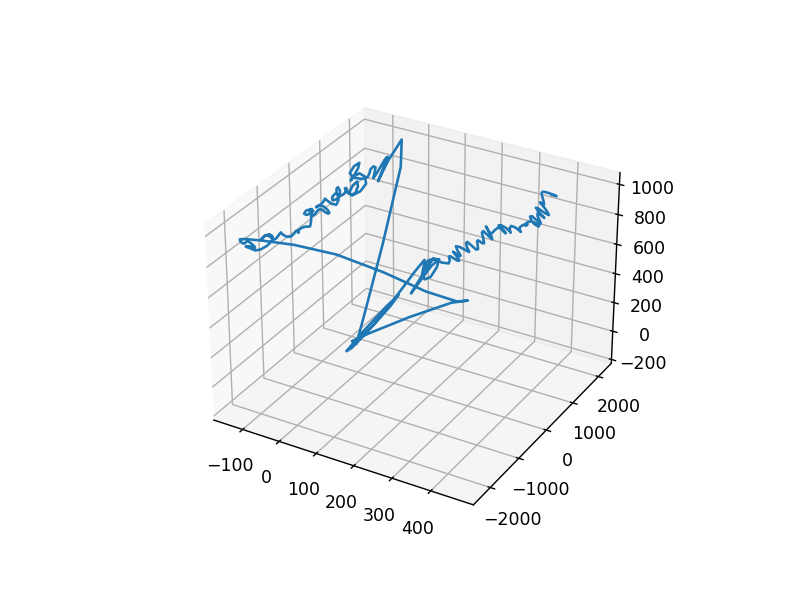

In [11]:
t = np.linspace(b[0], b[-1], lfin.shape[0]) # parametric interpolation points
crv = curve_factory.least_square_fit(lfin, b, t)
plot_3D_curve(crv)

From this we see that there exists several invalid measurement points where it is simply returned (0,0,0). We remove these from our data set and do a second fit

In [12]:
i, = np.where(np.abs(lfin[:,0]) == 0)

In [13]:
lfin[i,:]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [14]:
lfin = np.delete(lfin, i, axis=0)

<IPython.core.display.Javascript object>


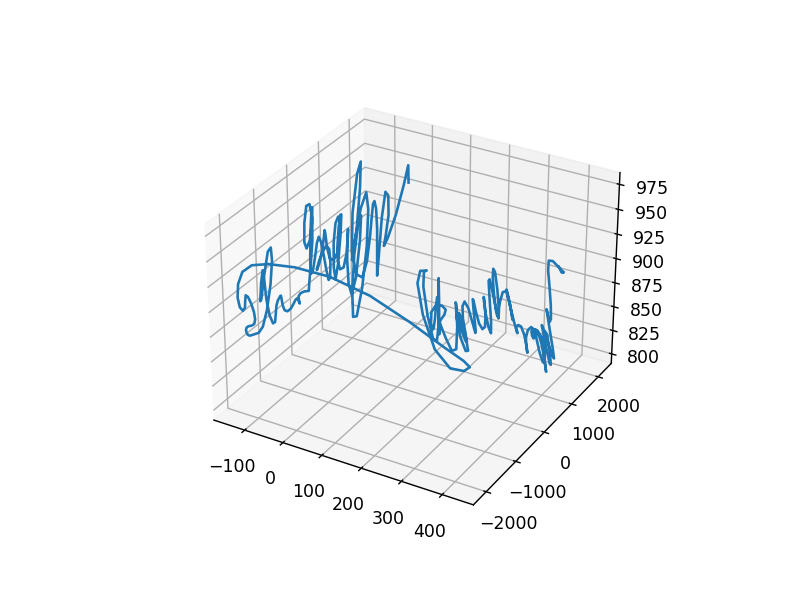

In [15]:
t = np.linspace(b[0], b[-1], lfin.shape[0]) # parametric interpolation points
crv = curve_factory.least_square_fit(lfin, b, t)
plot_3D_curve(crv)

### Problem 3
Explore the HIPPO dataset some more. What happens if you use a higher precision approximation (size of the BSplineBasis object `b`). 